In [104]:
import numpy as np
import cv2
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from scipy.sparse import diags, linalg
from PIL import Image

In [105]:
def compute_gradients(image_path):
    image = Image.open(image_path).convert('L')
    image_np = np.array(image, dtype=np.float32)

    gx = np.zeros_like(image_np)
    gy = np.zeros_like(image_np)

    gx[:, :-1] = image_np[:, 1:] - image_np[:, :-1]
    gy[:-1, :] = image_np[1:, :] - image_np[:-1]

    return image_np, gx, gy

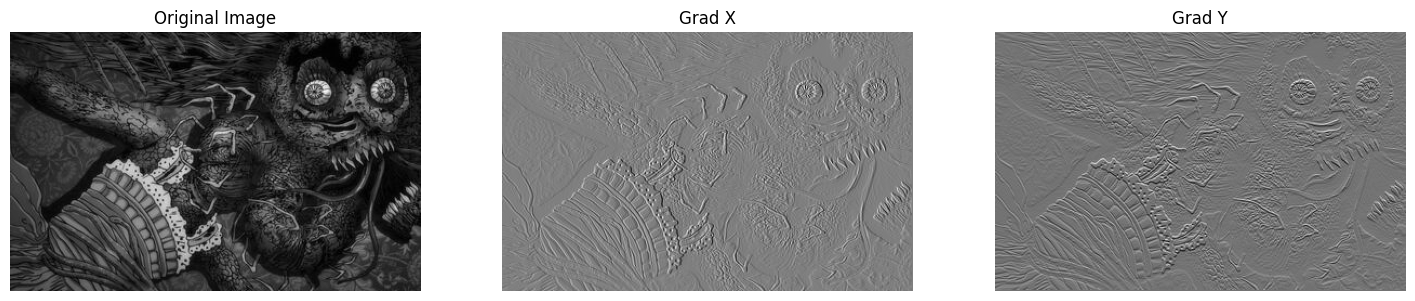

In [106]:
image_path = 'C:/labsCV/lab9/image.jpg'  
original_image, grad_x, grad_y = compute_gradients(image_path)


plt.figure(figsize=(18, 6))  
plt.subplot(1, 3, 1)  
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)  
plt.imshow(grad_x, cmap='gray')
plt.title("Grad X")
plt.axis('off')

plt.subplot(1, 3, 3)  
plt.imshow(grad_y, cmap='gray')
plt.title("Grad Y")
plt.axis('off')

plt.show()


C:\Users\marym\AppData\Local\Temp\ipykernel_13672\3533478685.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  diff = np.linalg.norm(f - f_prev) / np.linalg.norm(f_prev)


Iteration 0, diff: inf
Iteration 1, diff: 0.366648
Iteration 2, diff: 0.167609
Iteration 3, diff: 0.103030
Iteration 4, diff: 0.073232
Iteration 5, diff: 0.056503
Iteration 6, diff: 0.045903
Iteration 7, diff: 0.038615
Iteration 8, diff: 0.033303
Iteration 9, diff: 0.029261
Iteration 10, diff: 0.026080
Iteration 11, diff: 0.023511
Iteration 12, diff: 0.021393
Iteration 13, diff: 0.019615
Iteration 14, diff: 0.018102
Iteration 15, diff: 0.016799
Iteration 16, diff: 0.015665
Iteration 17, diff: 0.014669
Iteration 18, diff: 0.013788
Iteration 19, diff: 0.013003
Iteration 20, diff: 0.012299
Iteration 21, diff: 0.011666
Iteration 22, diff: 0.011092
Iteration 23, diff: 0.010570
Iteration 24, diff: 0.010094
Iteration 25, diff: 0.009657
Iteration 26, diff: 0.009256
Iteration 27, diff: 0.008885
Iteration 28, diff: 0.008543
Iteration 29, diff: 0.008225
Iteration 30, diff: 0.007929
Iteration 31, diff: 0.007653
Iteration 32, diff: 0.007395
Iteration 33, diff: 0.007154
Iteration 34, diff: 0.006927


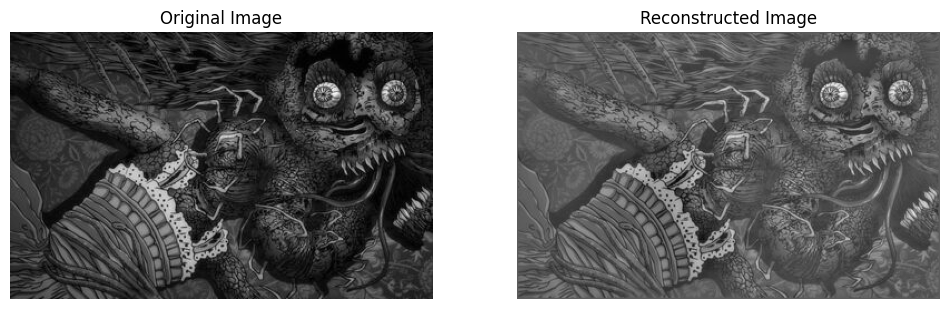

In [107]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def poisson_reconstruction(grad_x, grad_y, iterations=250, tol=1e-3):
    h, w = grad_x.shape
    f = np.zeros((h, w))  

    for it in range(iterations):
        f_prev = f.copy()
        
    
        for y in range(1, h - 1):
            for x in range(1, w - 1):
                f[y, x] = 0.25 * (f[y, x + 1] + f[y, x - 1] + f[y + 1, x] + f[y - 1, x]
                                  - (grad_x[y, x] - grad_x[y, x - 1])
                                  - (grad_y[y, x] - grad_y[y - 1, x]))
        
        diff = np.linalg.norm(f - f_prev) / np.linalg.norm(f_prev)
        print(f"Iteration {it}, diff: {diff:.6f}")
        if diff < tol:
            print(f"Accuracy reached. {it} iter, diff {diff:.6f}.")
            break

    return f

reconstructed_image = poisson_reconstruction(grad_x, grad_y)
reconstructed_image=(reconstructed_image - reconstructed_image.min()) / (reconstructed_image.max() - reconstructed_image.min()) * 255

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title("Reconstructed Image")
plt.axis('off')
plt.show()


C:\Users\marym\AppData\Local\Temp\ipykernel_13672\2651432023.py:27: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  solution = spsolve(A, b)


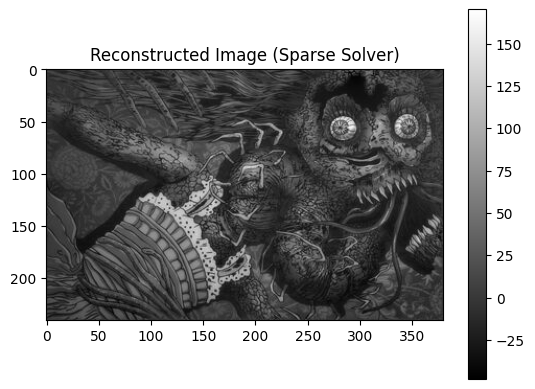

In [108]:
def reconstruct_image_sparse(grad_x, grad_y):
    h, w = grad_x.shape
    size = h * w
    A = lil_matrix((size, size))
    b = np.zeros(size)

    for y in range(h):
        for x in range(w):
            idx = y * w + x
            A[idx, idx] = 4  

            if x > 0:
                A[idx, idx - 1] = -1
            if x < w - 1:
                A[idx, idx + 1] = -1
            if y > 0:
                A[idx, idx - w] = -1
            if y < h - 1:
                A[idx, idx + w] = -1

            b[idx] = (
                (grad_x[y, x - 1] if x > 0 else 0) -
                (grad_x[y, x] if x < w - 1 else 0) +
                (grad_y[y - 1, x] if y > 0 else 0) -
                (grad_y[y, x] if y < h - 1 else 0)
            )
    solution = spsolve(A, b)

    return solution.reshape((h, w))

reconstructed_image_sparse = reconstruct_image_sparse(grad_x, grad_y)

plt.title("Reconstructed Image (Sparse Solver)")
plt.imshow(reconstructed_image_sparse, cmap='gray')
plt.colorbar()
plt.show()


In [112]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def poisson_blend_seidel(source, target, mask, offset=(0, 0), 
                         max_iter=5000, tol=1e-3):
    
    source_f = source.astype(np.float32)
    target_f = target.astype(np.float32)
    mask_f   = (mask > 127).astype(np.float32)  
    result = target_f.copy()

    H, W, C = source.shape
    tx, ty = offset  
    for ch in range(C):      
        src_channel = source_f[..., ch]
        trg_channel = result[..., ch]

        grad_x = np.zeros_like(src_channel)
        grad_y = np.zeros_like(src_channel)

        grad_x[:, :-1] = src_channel[:, 1:] - src_channel[:, :-1]
        grad_y[:-1, :] = src_channel[1:, :] - src_channel[:-1, :]

        f = np.zeros_like(src_channel)
        for y in range(H):
            for x in range(W):
                if mask_f[y, x] == 1:
                    f[y, x] = trg_channel[ty + y, tx + x]  
                else:
                    f[y, x] = 0.0  

        for it in range(max_iter):
            f_prev = f.copy()

            for yy in range(1, H - 1):
                for xx in range(1, W - 1):
                    if mask_f[yy, xx] == 1:
                       
                        f_up    = f[yy - 1, xx] if mask_f[yy - 1, xx] == 1 else trg_channel[ty + yy - 1, tx + xx]
                        f_down  = f[yy + 1, xx] if mask_f[yy + 1, xx] == 1 else trg_channel[ty + yy + 1, tx + xx]
                        f_left  = f[yy, xx - 1] if mask_f[yy, xx - 1] == 1 else trg_channel[ty + yy, tx + xx - 1]
                        f_right = f[yy, xx + 1] if mask_f[yy, xx + 1] == 1 else trg_channel[ty + yy, tx + xx + 1]

                        div = - ((grad_x[yy, xx] - grad_x[yy, xx - 1]) +
                                 (grad_y[yy, xx] - grad_y[yy - 1, xx]))

                        f[yy, xx] = 0.25 * (f_up + f_down + f_left + f_right + div)

            diff = np.linalg.norm(f - f_prev) / (np.linalg.norm(f_prev) + 1e-12)
            print(f"[Channel {ch}] Итерация {it}, diff = {diff:.6f}")
            if it % 100 == 0:  
                print(f"[Channel {ch}] Итерация {it}, diff = {diff:.6f}")

            if diff < tol:
                print(f"[Channel {ch}] Достигнута сходимость на итерации {it}, diff = {diff:.6f}")
                break
        

        for y in range(H):
            for x in range(W):
                if mask_f[y, x] == 1:
                    trg_channel[ty + y, tx + x] = np.clip(f[y, x], 0, 255)

        result[..., ch] = trg_channel

    return result.astype(np.uint8)


def main_seidel():
    source = cv2.imread('C:\\labsCV\\lab9\\image.jpg')
    target = cv2.imread('C:\\labsCV\\lab9\\bg.jpg')
    mask   = cv2.imread('C:\\labsCV\\lab9\\mask.png', 0) 
    tx = target.shape[1]//2 - source.shape[1]//2
    ty = target.shape[0]//2 - source.shape[0]//2
    offset = (tx, ty)

    blended = poisson_blend_seidel(source, target, mask, offset)

    cv2.imwrite("blended_result.jpg", blended)
    plt.imshow(cv2.cvtColor(blended, cv2.COLOR_BGR2RGB))
    plt.title("Poisson Blending (Gauss-Seidel)")
    plt.axis("off")
    plt.show()

[Channel 0] Итерация 0, diff = 0.127117
[Channel 0] Итерация 0, diff = 0.127117
[Channel 0] Итерация 1, diff = 0.048111
[Channel 0] Итерация 2, diff = 0.027980
[Channel 0] Итерация 3, diff = 0.019641
[Channel 0] Итерация 4, diff = 0.015281
[Channel 0] Итерация 5, diff = 0.012619
[Channel 0] Итерация 6, diff = 0.010817
[Channel 0] Итерация 7, diff = 0.009510
[Channel 0] Итерация 8, diff = 0.008515
[Channel 0] Итерация 9, diff = 0.007731
[Channel 0] Итерация 10, diff = 0.007094
[Channel 0] Итерация 11, diff = 0.006566
[Channel 0] Итерация 12, diff = 0.006120
[Channel 0] Итерация 13, diff = 0.005738
[Channel 0] Итерация 14, diff = 0.005407
[Channel 0] Итерация 15, diff = 0.005116
[Channel 0] Итерация 16, diff = 0.004858
[Channel 0] Итерация 17, diff = 0.004628
[Channel 0] Итерация 18, diff = 0.004421
[Channel 0] Итерация 19, diff = 0.004234
[Channel 0] Итерация 20, diff = 0.004064
[Channel 0] Итерация 21, diff = 0.003908
[Channel 0] Итерация 22, diff = 0.003765
[Channel 0] Итерация 23, di

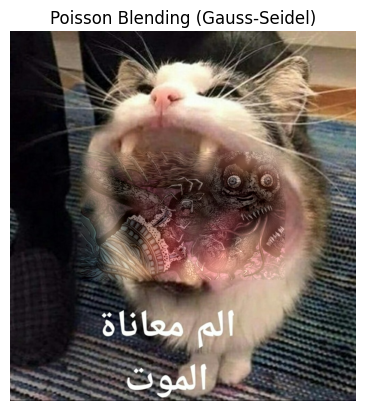

In [113]:
main_seidel()

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve

def reconstruct_image_sparse(grad_x, grad_y, mask, target_roi):
    h, w = grad_x.shape
    size = h * w

    A = lil_matrix((size, size), dtype=np.float32)
    b = np.zeros(size, dtype=np.float32)

    def idx(row, col):
        return row * w + col

    for y in range(h):
        for x in range(w):
            i = idx(y, x)

            if (y == 0 or y == h - 1 or x == 0 or x == w - 1
                or mask[y, x] == 0):
                A[i, i] = 1.0
                b[i] = target_roi[y, x]
            else:
                A[i, i] = 4.0

                if x - 1 >= 0:
                    if mask[y, x - 1] == 1:
                        A[i, i - 1] = -1.0
                    else:
                        b[i] += target_roi[y, x - 1]

                if x + 1 < w:
                    if mask[y, x + 1] == 1:
                        A[i, i + 1] = -1.0
                    else:
                        b[i] += target_roi[y, x + 1]

                if y - 1 >= 0:
                    if mask[y - 1, x] == 1:
                        A[i, i - w] = -1.0
                    else:
                        b[i] += target_roi[y - 1, x]

                if y + 1 < h:
                    if mask[y + 1, x] == 1:
                        A[i, i + w] = -1.0
                    else:
                        b[i] += target_roi[y + 1, x]

                gx_left  = grad_x[y, x - 1] if x - 1 >= 0 else 0
                gx_right = grad_x[y, x]     if x + 1 < w else 0

                gy_top    = grad_y[y - 1, x] if y - 1 >= 0 else 0
                gy_bottom = grad_y[y, x]     if y + 1 < h else 0

                b[i] -= (gx_right - gx_left) + (gy_bottom - gy_top)


    A_csr = A.tocsr()
    solution = spsolve(A_csr, b)
    return solution.reshape((h, w)).astype(np.float32)


def poisson_blend_sparse(source, target, mask, center):
    source_f = source.astype(np.float32)
    target_f = target.astype(np.float32)

    h_s, w_s, _ = source.shape
    cx, cy = center

    x0 = cx - w_s // 2
    y0 = cy - h_s // 2

    target_roi = target_f[y0:y0+h_s, x0:x0+w_s]

    mask_bin = (mask > 127).astype(np.uint8)

    blended_roi = np.zeros_like(target_roi)  

    for ch in range(3):
        src_ch = source_f[..., ch]

        grad_x = np.zeros_like(src_ch)
        grad_y = np.zeros_like(src_ch)

        grad_x[:, 1:] = src_ch[:, 1:] - src_ch[:, :-1]
        grad_y[1:, :] = src_ch[1:, :] - src_ch[:-1, :]

        f_ch = reconstruct_image_sparse(grad_x, grad_y,
                                        mask_bin,
                                        target_roi[..., ch])

        blended_roi[..., ch] = f_ch

    
    for y in range(h_s):
        for x in range(w_s):
            if mask_bin[y, x] == 1:
                target_f[y0 + y, x0 + x] = np.clip(blended_roi[y, x], 0, 255)
                


    return target_f.astype(np.uint8)


def main_sprase():
    source = cv2.imread('C:\\labsCV\\lab9\\image.jpg')
    target = cv2.imread('C:\\labsCV\\lab9\\bg.jpg')
    
    source = cv2.cvtColor(source, cv2.COLOR_BGR2RGB)
    target = cv2.cvtColor(target, cv2.COLOR_BGR2RGB)

    mask = 255 * np.ones(source.shape[:2], dtype=np.uint8)

    center = (target.shape[1] // 2, target.shape[0] // 2)

    output = poisson_blend_sparse(source, target, mask, center)
    
    plt.figure(figsize=(6,6))
    plt.imshow(output)
    plt.title('Sparse')
    plt.axis('off')
    plt.show()


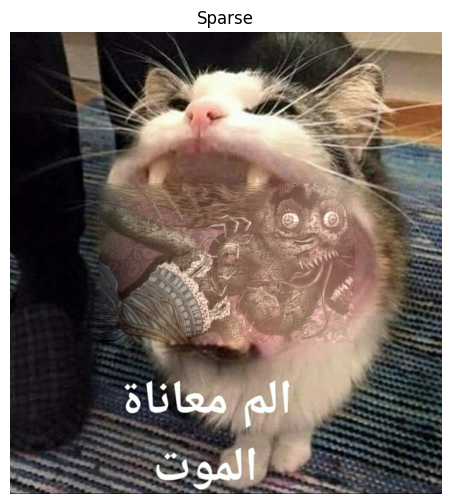

In [118]:
main_sprase()